# Molecular Hypernetwork Workflow

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite

import matplotlib.pyplot as plt
import seaborn as sns

import hypernetx as hnx
from hnxwidget import HypernetxWidget
from gnpsdata import workflow_fbmn, taskinfo

In [2]:
from workflow_utils import *

## Enter GNPS Task ID for FBMN

- **Feature-Based Molecular Networking in the GNPS Analysis Environment**
    Louis-Félix Nothias, Daniel Petras, Robin Schmid, et al.
    Nature Methods 2020 17, 905–908.
    DOI: 0.1038/s41592-020-0933-6
    
    Task ID (EDTA): `7f0b442ebdda45e8a926c729b8f48ff1`
    
    Task ID (NIST 1950): `daf3f0d7cec94104b2c9001739964c31`
    
    Task ID (NIST 1950 w/ IMS): `0d89db67b0974939a91cb7d5bfe87072`
    

- **Bioactivity-Based Molecular Networking for the Discovery of Drug Leads in Natural Product Bioassay-Guided Fractionation**.
    Louis-Félix Nothias, Mélissa Nothias-Esposito, Ricardo da Silva, et al.
    Journal of Natural Products 2018 81 (4), 758-767.
    DOI: 10.1021/acs.jnatprod.7b00737
    
    Task ID: `672d0a5372384cff8c47297c2048d789`


- **American Gut: an Open Platform for Citizen Science Microbiome Research**
    Daniel McDonald, Embriette Hyde, Justine W. Debelius, et al.
    mSystems 2018 3 (3), e00031-18.
    DOI: 10.1128/mSystems.00031-18
    
    Task ID: `0a8432b5891a48d7ad8459ba4a89969f`

In [3]:
# set Task ID here
task = "7f0b442ebdda45e8a926c729b8f48ff1"
# confirm task description
print(taskinfo.get_task_information(task)['description'])

MSV000082630 for FBMN Plasma Most_intense_spectrum FFM_v12_85k_SN3_2_traces_epd_true.ini


## Load FBMN and generate hypernetwork via clique reconstruction

In [4]:
# load FBMN as networkx graph
g = workflow_fbmn.get_graphml_network(task)
# construct bipartite clique graph
cliques = nx.make_clique_bipartite(g)

In [5]:
# store a table of important node attributes
node_attrs = ['parent mass', 'Adduct', 'Compound_Name', 'RTConsensus']
node_data = pd.DataFrame({attr: nx.get_node_attributes(g, attr) for attr in node_attrs})

In [6]:
# construct hypergraph from maximal cliques
HG = hnx.Hypergraph.from_bipartite(cliques, static=True).dual()

## Hypergraph $s$-components and statistics

In [7]:
%%time

comps = {}
for s in range(1,10):
    complist = list(HG.s_component_subgraphs(s))
    if complist:
        print(f"{len(complist)} {s}-component(s) found.")
        comps[s] = sorted(complist, key = lambda x: x.number_of_nodes(), reverse=True)
    else:
        break

62 1-component(s) found.
57 2-component(s) found.
34 3-component(s) found.
22 4-component(s) found.
15 5-component(s) found.
7 6-component(s) found.
5 7-component(s) found.
3 8-component(s) found.
1 9-component(s) found.
CPU times: user 1.03 s, sys: 5.85 ms, total: 1.04 s
Wall time: 1.04 s


In [ ]:
s_list = []
num_nodes = []
num_edges = []
num_annot = []
for s in comps:
    for i, c in enumerate(comps[s]):
        s_list.append(s)
        num_edges.append(c.number_of_edges())
        num_nodes.append(c.number_of_nodes())
        num_annot.append(node_data.Compound_Name.loc[c].notna().sum())

scomp_df = pd.DataFrame({
    "s": s_list,
    "num_nodes": num_nodes,
    "num_edges": num_edges,
    "num_annot": num_annot,
})

scomp_df.sort_values("num_edges")
scomp_df["comp_idx"]=scomp_df.groupby("s").cumcount()
scomp_df["coverage"]=scomp_df.groupby("s")["num_edges"].transform(pd.Series.cumsum) / HG.number_of_edges() * 100


/Users/shap825/anaconda3/envs/molecular-hypernet/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/shap825/anaconda3/envs/molecular-hypernet/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/shap825/anaconda3/envs/molecular-hypernet/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


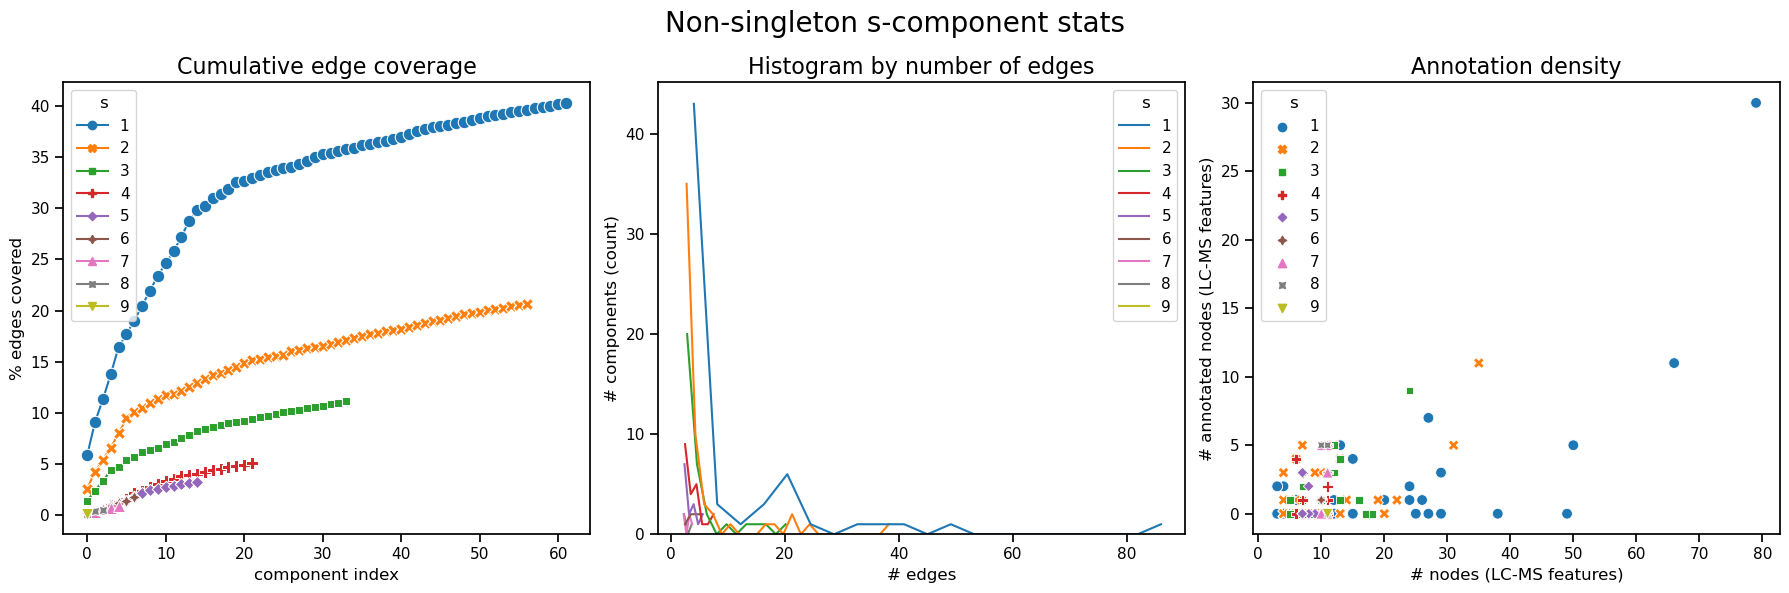

In [ ]:
with sns.plotting_context("notebook"):
    fig, ax = plt.subplots(1,3,figsize=(18,6), layout="tight")
    sns.lineplot(scomp_df, x="comp_idx", y="coverage", hue="s", ax=ax[0], palette="tab10", style="s", markers=True, dashes=False, markersize=9, legend="full")
    sns.histplot(scomp_df, x="num_edges",hue="s",ax=ax[1], palette="tab10", element="poly", common_bins=False, fill=False)
    sns.scatterplot(scomp_df, x="num_nodes", y="num_annot", hue="s", ax=ax[2], palette="tab10", style="s", s=60)
    ax[0].set_title('Cumulative edge coverage', fontsize=16)
    ax[0].set_xlabel('component index', fontsize=12)
    ax[0].set_ylabel('% edges covered', fontsize=12)
    ax[1].set_title('Histogram by number of edges', fontsize=16)
    ax[1].set_xlabel('# edges', fontsize=12)
    ax[1].set_ylabel('# components (count)', fontsize=12)
    ax[2].set_title('Annotation density', fontsize=16)
    ax[2].set_xlabel('# nodes (LC-MS features)', fontsize=12)
    ax[2].set_ylabel('# annotated nodes (LC-MS features)', fontsize=12)
    fig.suptitle('Non-singleton s-component stats', fontsize=20);

## Explore components

Filter data by m/z and/or retention time using `filter_LCMS(node_data, ...)`.

Valid parameters:
- `mz`: m/z value or tuple of (min m/z, max m/z) specifying a range of values
- `mz_rtol`: m/z match relative tolerance (e.g., `mz_rtol=2e-5` for 20ppm); not used for range m/z
- `rt`: retention time (RTConsensus) value or tuple of (min retention time, max retention time) specifying a range of values
- `rt_atol`: retention time match absolute tolerance; not used for range retention time

In [9]:
# EDTA from FBMN example
mz_filtered = filter_LCMS(node_data, mz=293.093, mz_rtol=2e-5)
mz_filtered

,parent mass,Adduct,Compound_Name,RTConsensus
253,293.0978,M+H,Ethylenediaminetetraacetic acid EDTA,27.1764


You can also filter data for specific compound names and/or adducts using `filter_annotation(node_data, compound=compound, adduct=adduct)`.

In [10]:
name_filtered = filter_annotation(node_data, compound='Ethylenediaminetetraacetic acid EDTA')
name_filtered

,parent mass,Adduct,Compound_Name,RTConsensus
161,315.0789,M+Na,Ethylenediaminetetraacetic acid EDTA,25.9150
253,293.0978,M+H,Ethylenediaminetetraacetic acid EDTA,27.1764


Find  $s$-components containing the filtered nodes using `search_components(comps, filtered_data, s=s)`, default `s=1`. By default this returns a list of indices in `comps[s]`. Pass optional parameter `return_index=False` to return a list of the components themselves (as `hnx.Hypergraph` objects).

In [11]:
comps_filtered = search_components(comps, mz_filtered)

Print a summary of any $s$-component using `summarize_component(comp_idx, comps, node_data, s=s)`, default `s=1`. $s$-components are ordered from largest (`comp_idx=0`) to smallest by number of nodes.

In [12]:
for comp_idx in comps_filtered:
    summarize_component(comp_idx, comps, node_data)

1-component (11):
	24 nodes, 18 edges
	min m/z: 114.055, max m/z: 991.1273
	min RT: 19.3789, max RT: 353.2394
	annotated compound(s): Ethylenediaminetetraacetic acid EDTA; Massbank:PR100077 (-)-Nicotine|beta-Pyridyl-alpha-N-methylpyrrolidine|(-)-Nicotine ( solution 1.0 mg/mL+/-5% in methanol)
	adduct(s): M+H, [M+H]+


In [13]:
# label nodes by compound name if available, otherwise parent mass (for widget visualization)
default_labels = nx.get_node_attributes(g, 'parent mass')
default_labels.update(nx.get_node_attributes(g, 'Compound_Name'))

Display the interactive widget using `visualize_component(comp_idx, comps, node_labels, node_data, s=s)`, default `s=1`.

In [ ]:
# this may throw a UserWarning, but should still display the widget correctly
visualize_component(11, comps, default_labels, node_data)

## View FBMN component and MS2 spectra

Get a link to view the corresponding component in the original FBMN using `link_network(comp_idx, fbmn_graph, s=s)`. This link will open the GNPS Browser Network Visualizer in a new tab.

In [15]:
link_network(11, comps, g)

Generate the USI associated with a node using `get_usi(task, scan_id)`. The `scan_id` is the default integer label assigned to each node, which will be displayed in parentheses next to the bolded parent mass or compound name shown on hover/select in the widget.

Get a link to view MS2 spectra using `link_spectra(usi)`. This link will open the Metabolomics Spectrum Resolver in a new tab.

In [16]:
# MS2 spectra for 10 nodes in the largest 1-component
for scan in list(comps[1][0])[:10]:
    display(link_spectra(get_usi(task, scan)))

Alternatively, an image of the spectra can be grabbed from Metabolomics Spectrum Resolver and displayed within the notebook using `display_spectra(usi)`. Double click to enlarge the image.

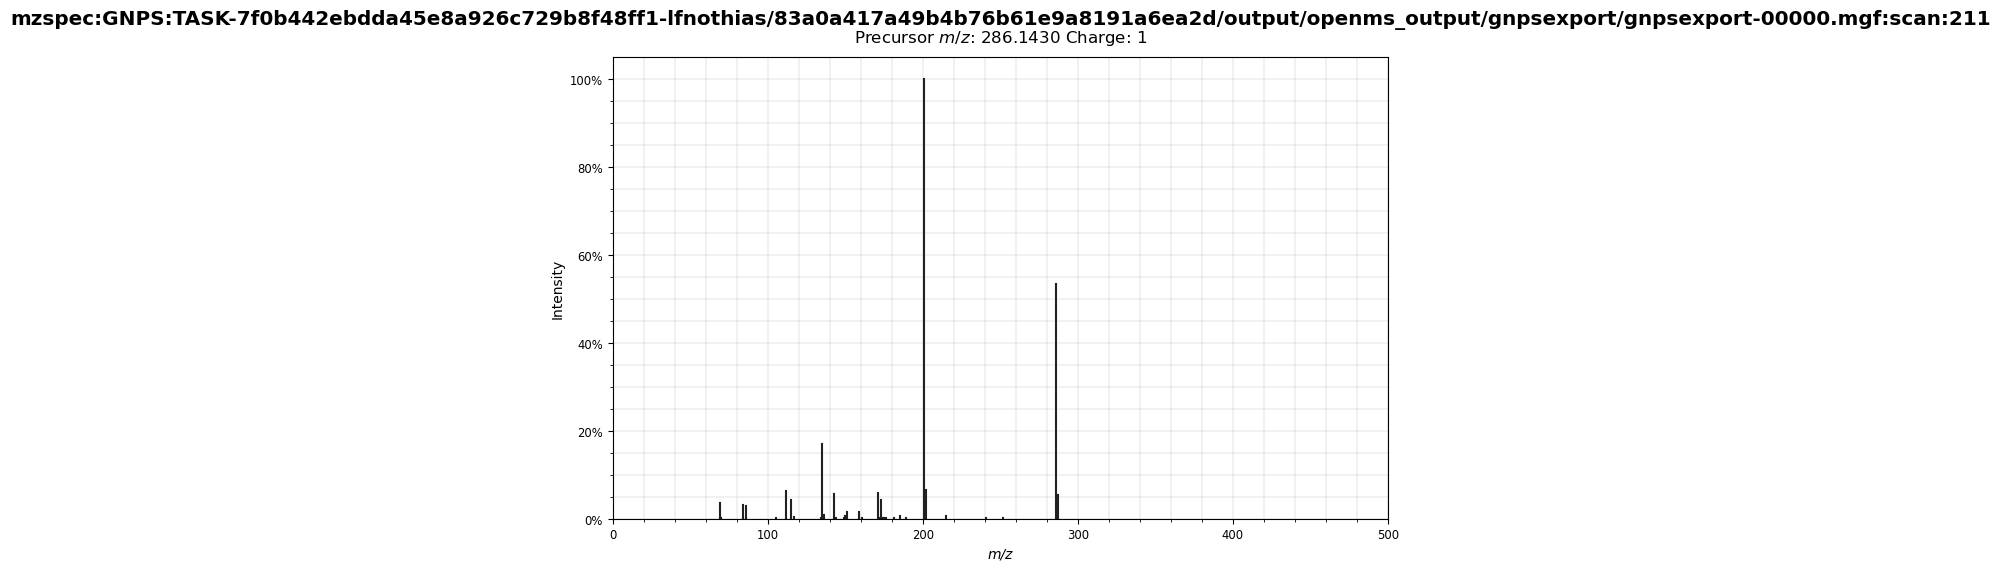

In [17]:
display_spectra(get_usi(task,'211'))